In [2]:
import numpy as np
from scipy.special import factorial
from scipy import sparse
from farray import apply_matrix, reshape_vector
import matplotlib.pyplot as plt

class UniformPeriodicGrid:

    def __init__(self, N, length):
        self.values = np.linspace(0, length, N, endpoint=False)
        self.dx = self.values[1] - self.values[0]
        self.length = length
        self.N = N

class Domain:

    def __init__(self, grids):
        self.dimension = len(grids)
        self.grids = grids
        shape = []
        for grid in self.grids:
            shape.append(grid.N)
        self.shape = shape

    def values(self):
        v = []
        for i, grid in enumerate(self.grids):
            grid_v = grid.values
            grid_v = reshape_vector(grid_v, self.dimension, i)
            v.append(grid_v)
        return v

    def plotting_arrays(self):
        v = []
        expanded_shape = np.array(self.shape, dtype=np.int)
        expanded_shape += 1
        for i, grid in enumerate(self.grids):
            grid_v = grid.values
            grid_v = np.concatenate((grid_v, [grid.length]))
            grid_v = reshape_vector(grid_v, self.dimension, i)
            grid_v = np.broadcast_to(grid_v, expanded_shape)
            v.append(grid_v)
        return v


class Difference:

    def __matmul__(self, other):
        return apply_matrix(self.matrix, other, axis=self.axis)


class DifferenceUniformGrid(Difference):

    def __init__(self, derivative_order, convergence_order, grid, axis=0, stencil_type='centered'):
        if stencil_type == 'centered' and convergence_order % 2 != 0:
            raise ValueError("Centered finite difference has even convergence order")

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.stencil_type = stencil_type
        self.axis = axis
        self._stencil_shape(stencil_type)
        self._make_stencil(grid)
        self._build_matrix(grid)

    def _stencil_shape(self, stencil_type):
        dof = self.derivative_order + self.convergence_order

        if stencil_type == 'centered':
            # cancellation if derivative order is even
            dof = dof - (1 - dof % 2)
            j = np.arange(dof) - dof//2

        self.dof = dof
        self.j = j

    def _make_stencil(self, grid):

        # assume constant grid spacing
        self.dx = grid.dx
        i = np.arange(self.dof)[:, None]
        j = self.j[None, :]
        S = 1/factorial(i)*(j*self.dx)**i

        b = np.zeros( self.dof )
        b[self.derivative_order] = 1.

        self.stencil = np.linalg.solve(S, b)

    def _build_matrix(self, grid):
        shape = [grid.N] * 2
        matrix = sparse.diags(self.stencil, self.j, shape=shape)
        matrix = matrix.tocsr()
        jmin = -np.min(self.j)
        if jmin > 0:
            for i in range(jmin):
                matrix[i,-jmin+i:] = self.stencil[:jmin-i]

        jmax = np.max(self.j)
        if jmax > 0:
            for i in range(jmax):
                matrix[-jmax+i,:i+1] = self.stencil[-i-1:]
        self.matrix = matrix


class DifferenceNonUniformGrid(Difference):

    def __init__(self, derivative_order, convergence_order, grid, axis=0, stencil_type='centered'):
        if (derivative_order + convergence_order) % 2 == 0:
            raise ValueError("The derivative plus convergence order must be odd for centered finite difference")

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.stencil_type = stencil_type
        self.axis = axis
        self._stencil_shape(stencil_type)
        self._make_stencil(grid)
        self._build_matrix(grid)

    def _stencil_shape(self, stencil_type):
        dof = self.derivative_order + self.convergence_order
        j = np.arange(dof) - dof//2
        self.dof = dof
        self.j = j

    def _make_stencil(self, grid):
        self.dx = grid.dx_array(self.j)

        i = np.arange(self.dof)[None, :, None]
        dx = self.dx[:, None, :]
        S = 1/factorial(i)*(dx)**i

        b = np.zeros( (grid.N, self.dof) )
        b[:, self.derivative_order] = 1.

        self.stencil = np.linalg.solve(S, b)

    def _build_matrix(self, grid):
        shape = [grid.N] * 2
        diags = []
        for i, jj in enumerate(self.j):
            if jj < 0:
                s = slice(-jj, None, None)
            else:
                s = slice(None, None, None)
            diags.append(self.stencil[s, i])
        matrix = sparse.diags(diags, self.j, shape=shape)

        matrix = matrix.tocsr()
        jmin = -np.min(self.j)
        if jmin > 0:
            for i in range(jmin):
                matrix[i,-jmin+i:] = self.stencil[i, :jmin-i]

        jmax = np.max(self.j)
        if jmax > 0:
            for i in range(jmax):
                matrix[-jmax+i,:i+1] = self.stencil[-jmax+i, -i-1:]

        self.matrix = matrix


class CenteredFiniteDifference(Difference):

    def __init__(self, grid, axis=0):
        self.axis = axis
        h = grid.dx
        N = grid.N
        j = [-1, 0, 1]
        diags = np.array([-1/(2*h), 0, 1/(2*h)])
        matrix = sparse.diags(diags, offsets=j, shape=[N,N])
        matrix = matrix.tocsr()
        matrix[-1, 0] = 1/(2*h)
        matrix[0, -1] = -1/(2*h)
        self.matrix = matrix



In [3]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
from scipy.special import factorial
from collections import deque
from farray import axslice, apply_matrix

class StateVector:

    def __init__(self, variables, axis=0):
        self.axis = axis
        var0 = variables[0]
        shape = list(var0.shape)
        self.N = shape[axis]
        shape[axis] *= len(variables)
        self.shape = tuple(shape)
        self.data = np.zeros(shape)
        self.variables = variables
        self.gather()

    def gather(self):
        for i, var in enumerate(self.variables):
            np.copyto(self.data[axslice(self.axis, i*self.N, (i+1)*self.N)], var)

    def scatter(self):
        for i, var in enumerate(self.variables):
            np.copyto(var, self.data[axslice(self.axis, i*self.N, (i+1)*self.N)])


class Timestepper:

    def __init__(self):
        self.t = 0
        self.iter = 0
        self.dt = None

    def step(self, dt):
        self.X.gather()
        self.X.data = self._step(dt)
        self.X.scatter()
        self.t += dt
        self.iter += 1
    
    def evolve(self, dt, time):
        while self.t < time - 1e-8:
            self.step(dt)

            
class ExplicitTimestepper(Timestepper):

    def __init__(self, eq_set):
        super().__init__()
        self.X = eq_set.X
        self.F = eq_set.F
        
        
class Multistage(ExplicitTimestepper):

    def __init__(self, eq_set, stages, a, b):
        super().__init__(eq_set)
        self.stages = stages
        self.a = a
        self.b = b

        self.X_list = []
        self.K_list = []
        for i in range(self.stages):
            self.X_list.append(StateVector([np.copy(var) for var in self.X.variables]))
            self.K_list.append(np.copy(self.X.data))

    def _step(self, dt):
        X = self.X
        X_list = self.X_list
        K_list = self.K_list
        stages = self.stages

        np.copyto(X_list[0].data, X.data)
        for i in range(1, stages):
            K_list[i-1] = self.F(X_list[i-1])

            np.copyto(X_list[i].data, X.data)
            # this loop is slow -- should make K_list a 2D array
            for j in range(i):
                X_list[i].data += self.a[i, j]*dt*K_list[j]

        K_list[-1] = self.F(X_list[-1])

        # this loop is slow -- should make K_list a 2D array
        for i in range(stages):
            X.data += self.b[i]*dt*K_list[i]

        return X.data


def RK22(eq_set):
    a = np.array([[  0,   0],
                  [1/2,   0]])
    b = np.array([0, 1])
    return Multistage(eq_set, 2, a, b)


class ImplicitTimestepper(Timestepper):

    def __init__(self, eq_set, axis):
        super().__init__()
        self.axis = axis
        self.X = eq_set.X
        self.M = eq_set.M
        self.L = eq_set.L

    def _LUsolve(self, data):
        if self.axis == 0:
            return self.LU.solve(data)
        elif self.axis == len(data.shape)-1:
            return self.LU.solve(data.T).T
        else:
            raise ValueError("Can only do implicit timestepping on first or last axis")
            
            
class CrankNicolson(ImplicitTimestepper):

    def _step(self, dt):
        if dt != self.dt:
            self.LHS = self.M + dt/2*self.L
            self.RHS = self.M - dt/2*self.L
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
        self.dt = dt
        return self._LUsolve(apply_matrix(self.RHS, self.X.data, self.axis))

In [38]:
class ReactionDiffusion2D:
    
    def __init__(self, c, D, dx2, dy2):
        self.X=c
        self.t = 0
        self.iter = 0
        self.dt = None
        self.dx2 = dx2
        self.dy2 = dy2
        self.D = D
    
    def step(self, dt):
        self.dt = dt
        c = self.X
        #print(c[:,0])
        dx2 = self.dx2.matrix
        dy2 = self.dy2.matrix
        plot_2D(c)
        #plot_2D(dx2.A)
        #plot_2D(dy2.A)
        Nx = len(c[0])
        Ny = len(c[:,0])
        
        Mx = sparse.eye(Nx, Nx)
        My = sparse.eye(Ny, Ny)
        
        spaceSteps = 1
        while spaceSteps <= 3:
            if spaceSteps % 2 == 1:
                i=0
                c_old = c
                F1 = c_old*(1-c_old)
                K1 = c_old + (dt/4)*F1
                F2 = K1*(1-K1)
                while i < Nx:
                    LHS = (Mx - (dt/4)*self.D*dx2)
                    RHS = (Mx + (dt/4)*self.D*dx2)@c_old[i] + (dt/2)*F2[i]
                    c[i] = spla.spsolve(LHS,RHS)
                    i+=1
            else:
                i=0
                c_old = c
                F1 = c_old*(1-c_old)
                K1 = c_old + (dt/2)*F1
                F2 = K1*(1-K1)
                while i < Ny:
                    LHS = (My - (dt/2)*self.D*dy2)
                    RHS = (My + (dt/2)*self.D*dy2)@c_old[:,i] + dt*F2[:,i]
                    c[:,i] = spla.spsolve(LHS,RHS)
                    i+=1
                    
            plot_2D(c_old)
            #print(np.max(c_old))
            spaceSteps += 1
        
        self.t += dt
        self.iter += 1
        pass

class ViscousBurgers:
    
    def __init__(self, u, nu, d, d2):
        self.u = u
        self.X = StateVector([u])
        
        N = len(u)
        self.M = sparse.eye(N, N)
        self.L = -nu*d2.matrix
        
        f = lambda X: -X.data*(d @ X.data)
        
        self.F = f


class Wave:
    
    def __init__(self, u, v, d2):
        self.X = StateVector([u, v])
        N = len(u)
        I = sparse.eye(N, N)
        Z = sparse.csr_matrix((N, N))

        M00 = I
        M01 = Z
        M10 = Z
        M11 = I
        self.M = sparse.bmat([[M00, M01],
                              [M10, M11]])

        L00 = Z
        L01 = -I
        L10 = -d2.matrix
        L11 = Z
        self.L = sparse.bmat([[L00, L01],
                              [L10, L11]])

        
        self.F = lambda X: 0*X.data


class SoundWave:

    def __init__(self, u, p, d, rho0, p0):
        pass


class ReactionDiffusion:
    
    def __init__(self, c, d2, c_target, D):
        pass
    
def plot_2D(matrix, title='FD matrix'):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.title(title)
    plt.tight_layout()

C:\Users\Owner\AppData\Local\Temp/ipykernel_6476/2665031782.py:122: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


0.7049855986662722
0.7151226887433921
0.7196400410476265
0.724115043058576
0.7338436082262623
0.7381761648909094
0.7424643963744901
0.7517682723611933
0.7559090723409835
0.7600041213251124
0.7688720833575475
0.7728163960301461
0.7767140539976943
0.7851395535471818
0.7888847494812817


C:\Users\Owner\AppData\Local\Temp/ipykernel_6476/2665031782.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3,3))


0.792582873162948
0.8005636978095375
0.8041090864954485
0.8076074288922509
0.8151453055116882
0.8184919493159979
0.8217919691524767
0.8288921299443116
0.8320426431216091
0.8351473013989748
0.8418180307166504
0.8447763715099776
0.8476899229535273
0.8539421007290119
0.856713363536812
0.8594411496335025
0.8652878046603417
0.867878018054643
0.8704262671651509
0.8758821508363042
0.8782980859832572
0.8806737247821513
0.8857549132537822
0.8880039060923811
0.8902143854139205
0.8949379157193376
0.8970277051550243
0.8990808422530925
0.903464385713877
0.9054029691181643
0.9073068074197189
0.9113683818454061
0.9131638883402293
0.9149265749979661
0.9186842956502441
0.9203448770014638
0.921974557935154
0.9254464260508102
0.9269801644932604
0.9284848961424139
0.9316886229368164
0.9331034548901782
0.9344911315686921
0.937443995042955
0.9387476494358908


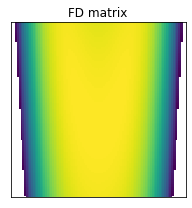

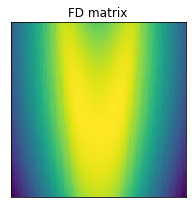

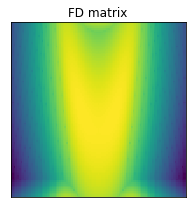

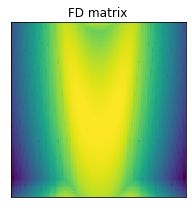

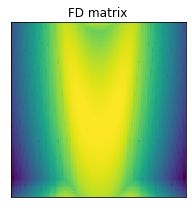

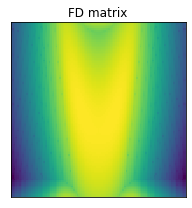

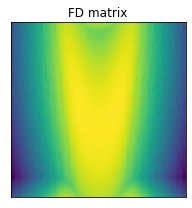

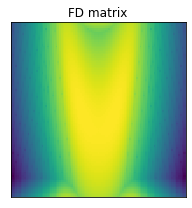

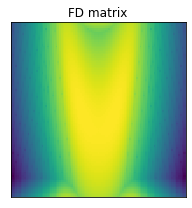

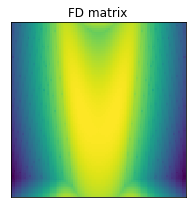

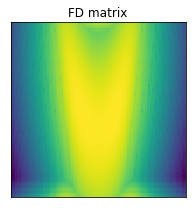

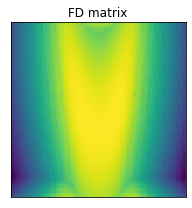

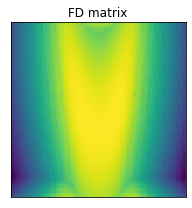

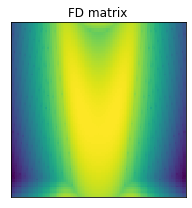

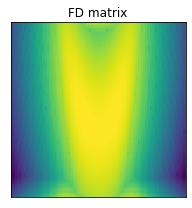

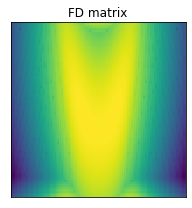

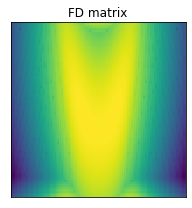

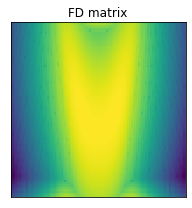

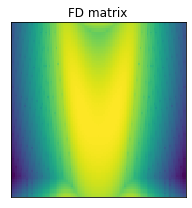

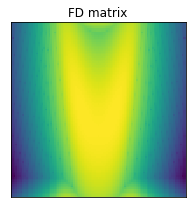

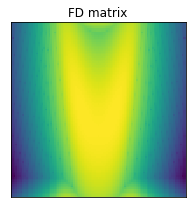

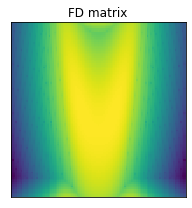

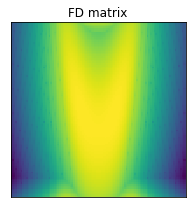

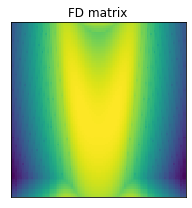

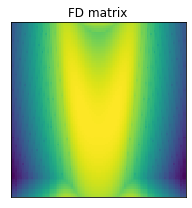

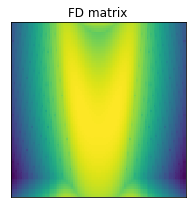

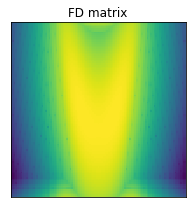

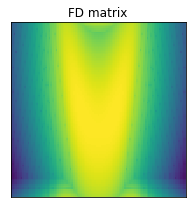

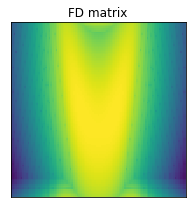

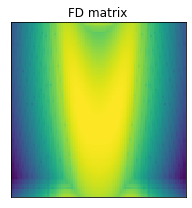

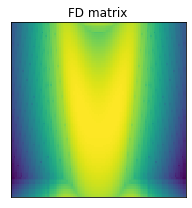

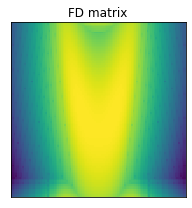

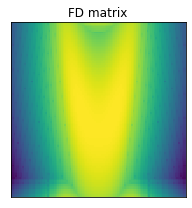

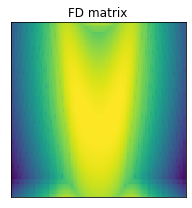

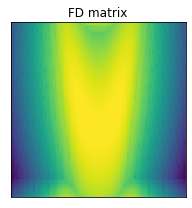

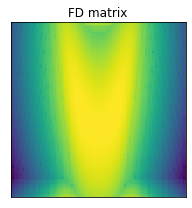

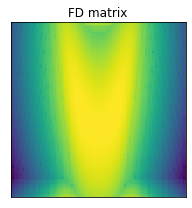

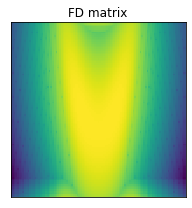

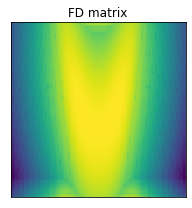

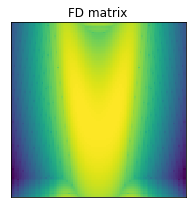

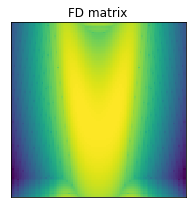

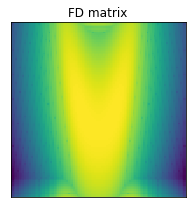

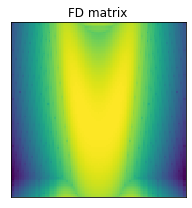

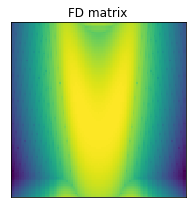

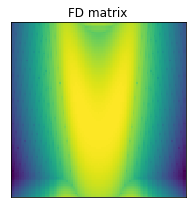

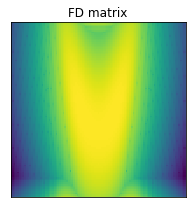

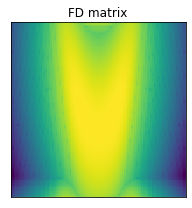

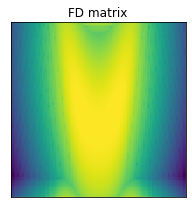

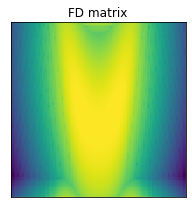

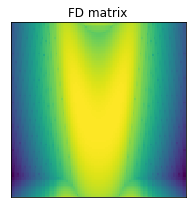

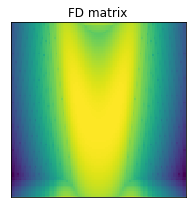

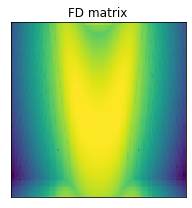

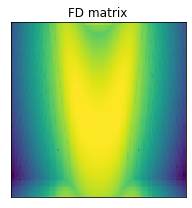

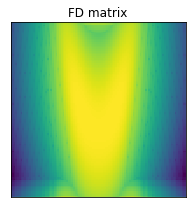

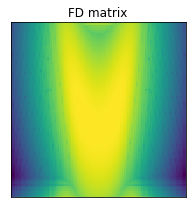

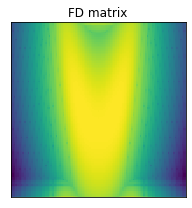

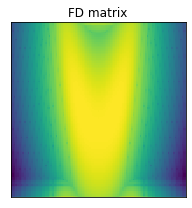

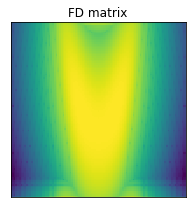

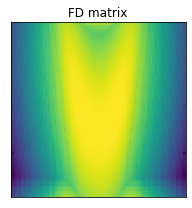

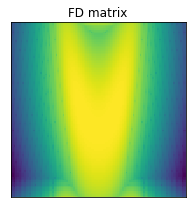

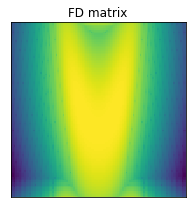

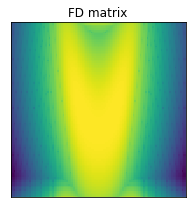

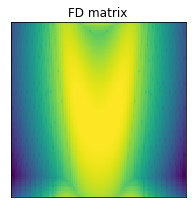

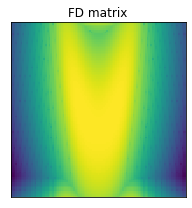

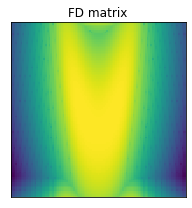

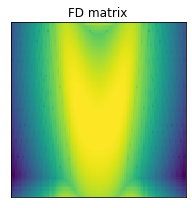

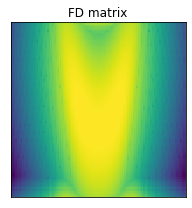

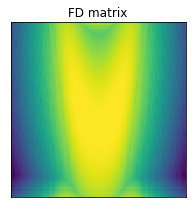

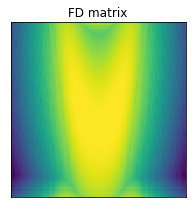

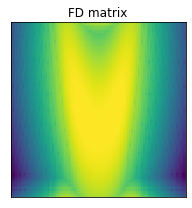

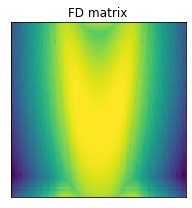

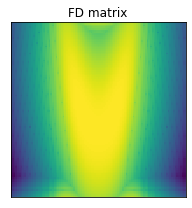

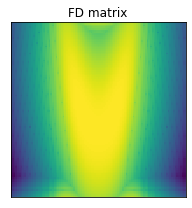

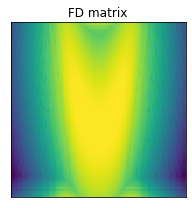

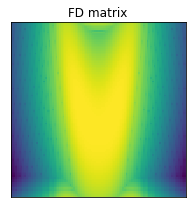

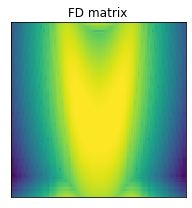

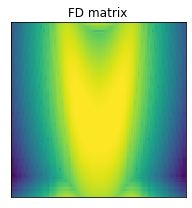

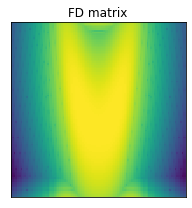

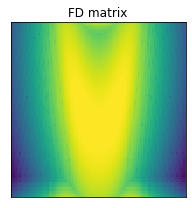

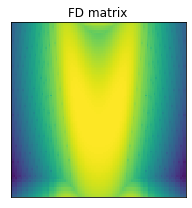

In [39]:
test=0

error_RD = {(50,0.5):3e-3, (50,0.25):2.5e-3, (50,0.125):2.5e-3,(100,0.5):4e-4, (100,0.25):2e-4, (100,0.125):1e-4, (200,0.5):8e-5, (200,0.25):2e-5, (200,0.125):5e-6}
resolution = [100, 50, 100, 200]
alpha = [0.5, 0.25, 0.125]

grid_x = UniformPeriodicGrid(resolution[0], 20)
grid_y = UniformPeriodicGrid(resolution[0], 20)
domain = Domain((grid_x, grid_y))
x, y = domain.values()

IC = np.exp(-(x+(y-10)**2-14)**2/8)*np.exp(-((x-10)**2+(y-10)**2)/10)

c = np.zeros(domain.shape)
c[:] = IC
D = 1e-2

dx2 = DifferenceUniformGrid(2, 8, grid_x, 0)
dy2 = DifferenceUniformGrid(2, 8, grid_y, 1)

rd_problem = ReactionDiffusion2D(c, D, dx2, dy2)

dt = alpha[1]*grid_x.dx

while rd_problem.t < 1-1e-5:
    rd_problem.step(dt)


In [ ]:
c = np.array([[0, 1],[0,4],[9,99]])
np.shape(c)
d=np.zeros(np.shape(c))
print(c*(1-c))

In [29]:
np.shape(c)
type(c)

numpy.ndarray

In [15]:
3%2

1

In [24]:
np.shape([1, 2])

(2,)